# A machine learning decision tree approach

The iMeta algorithm is essentially a decision tree algorithm, where the variables and threshold for the decisions at each step are manually specified based on human analysis. The simplest way to apply machine learning techniques to the problem would be to use a similar structure to iMeta, which is a decision tree, but use standard ML training techiniques to learn the parameters such as what thresholds to use and how many branches/leaves to have in the tree for the best results. 

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipywidgets
import time

In [3]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
from xbt_dataset import XbtDataset

In [6]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1996,2015),
    'pangeo': (1966,2015)
}

In [8]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year']

In [9]:
classifier_class = sklearn.ensemble.RandomForestClassifier
classifier_opts = {}

In [10]:
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

load the following features: ['country', 'institute', 'platform', 'cruise_number', 'instrument', 'imeta_applied', 'max_depth', 'lat', 'lon', 'id', 'date']


## Data preparation

We are only testing on the labelled data, to be able to evluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

In [11]:
xbt_labelled = xbt_full_dataset.filter_obs('labelled', 'labelled')

extracting labelled


In [12]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [13]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are currently training and evaulating separately for model and manufacturer. We will also need to train and evaulate together as this is ultimately what is wanted (a combined probe model and manufacturer field).

We are using the default 80/20 split in scikit-learn for now. Further work will need to do proper cross validation where several different splits are randomly selected to verify our results are not an artifact of the randomly chosen split.

In [14]:
xbt_train_all, xbt_test_all = xbt_labelled.train_test_split(split_on_feature='year')

In [15]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [16]:
X_train_all = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
y_model_train_all = xbt_train_all.filter_features(['model']).get_ml_dataset()[0]
y_manuf_train_all = xbt_train_all.filter_features(['manufacturer']).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features(['instrument']).get_ml_dataset()[0]
y_model_test_all = xbt_test_all.filter_features(['model']).get_ml_dataset()[0]
y_manuf_test_all = xbt_test_all.filter_features(['manufacturer']).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features(['instrument']).get_ml_dataset()[0]

## Training the classifier

We are using the scikit-learn classifier as the closest analogue to the structure of the iMeta algorithm. This tree can have many more nodes and leaves than iMeta though. it is quick to train and evaluate so it is a useful starting point for setting up the ML processing pipelines, as all the scikit-learn classifiers have a common interface. 

For the model and manufacturer, we train a Decision ree Classifier, then use it to predict values for the train and test sets. We then calculate the accuracy metrics for each for the whole dataset. 

I am using precision, recall and F1 as fairly standard ML metrics of accuracy. Recall is what has been used in the two previous papers (Palmer et. al, Leahy and Llopis et al) so that is the focus. Support is a useful to see what proportion of the profiles in the dataset belong to each of the different classes.

In [17]:
metrics_per_class_all = {}
metrics_avg_all = {}

In [18]:
clf_dt_model1 = classifier_class(**classifier_opts)
clf_dt_model1.fit(X_train_all,y_model_train_all)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
y_res_train_model_all = clf_dt_model1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_model_train_all, y_res_train_model_all, )
metrics_per_class_all.update( {
    'precision_model_train': metrics1[0],
    'recall_model_train': metrics1[1],
    'f1_model_train': metrics1[2],
    'support_model_train': metrics1[3],
})

metrics_avg_all.update({
    'precision_model_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_model_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_model_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [20]:
y_res_test_model = clf_dt_model1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_model_test_all, y_res_test_model,)
metrics_per_class_all.update( {
    'precision_model_test': metrics1[0],
    'recall_model_test': metrics1[1],
    'f1_model_test': metrics1[2],
    'support_model_test': metrics1[3],
})

metrics_avg_all.update({
    'precision_model_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_model_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_model_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [21]:
clf_dt_manuf1 = classifier_class(**classifier_opts)
clf_dt_manuf1.fit(X_train_all,y_manuf_train_all)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
y_res_train_manuf_all = clf_dt_manuf1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_manuf_train_all, y_res_train_manuf_all, )
metrics_per_class_all.update( {
    'precision_manuf_train': metrics1[0],
    'recall_manuf_train': metrics1[1],
    'f1_manuf_train': metrics1[2],
    'support_manuf_train': metrics1[3],
})

metrics_avg_all.update({
    'precision_manuf_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_manuf_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_manuf_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})



In [23]:
y_res_test_manuf_all = clf_dt_manuf1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_manuf_test_all, y_res_test_manuf_all, )
metrics_per_class_all.update( {
    'precision_manuf_test': metrics1[0],
    'recall_manuf_test': metrics1[1],
    'f1_manuf_test': metrics1[2],
    'support_manuf_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_manuf_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_manuf_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_manuf_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})


In [24]:
clf_dt_instr1 = classifier_class(**classifier_opts)
clf_dt_instr1.fit(X_train_all,y_instr_train_all)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
y_res_train_instr_all = clf_dt_instr1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_train_all, y_res_train_instr_all, )
metrics_per_class_all.update( {
    'precision_instr_train': metrics1[0],
    'recall_instr_train': metrics1[1],
    'f1_instr_train': metrics1[2],
    'support_instr_train': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [26]:
y_res_test_instr_all = clf_dt_instr1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_test_all, y_res_test_instr_all, )
metrics_per_class_all.update( {
    'precision_instr_test': metrics1[0],
    'recall_instr_test': metrics1[1],
    'f1_instr_test': metrics1[2],
    'support_instr_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [27]:
metrics_per_class_all['model'] = list(xbt_labelled._feature_encoders['model'].categories_[0])
metrics_per_class_all['manufacturer'] = list(xbt_labelled._feature_encoders['manufacturer'].categories_[0])
metrics_per_class_all['instrument'] = list(xbt_labelled._feature_encoders['instrument'].categories_[0])

In [28]:
df_metrics_per_class_model = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'model' in k1})
df_metrics_per_class_manuf = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'manuf' in k1})
df_metrics_per_class_instr = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'instr' in k1})

In [29]:
df_metrics_avg = pandas.DataFrame.from_dict({
    'target': ['model_train','model_test','manufacturer_train','manufacturer_test','instrument_train','instrument_test'],
    'precision': [v1 for k1,v1 in metrics_avg_all.items() if 'precision' in k1],
    'recall': [v1 for k1,v1 in metrics_avg_all.items() if 'recall' in k1],
    'f1': [v1 for k1,v1 in metrics_avg_all.items() if 'f1' in k1],
})

In [30]:
df_metrics_avg

,target,precision,recall,f1
0,model_train,0.997456,0.997378,0.997414
1,model_test,0.933800,0.932827,0.933293
2,manufacturer_train,0.999938,0.999933,0.999935
3,manufacturer_test,0.994233,0.994253,0.994241
4,instrument_train,0.997435,0.997358,0.997394
5,instrument_test,0.932315,0.931393,0.931832


# Classification result plots

The plots below show the results for the whole XBT dataset. We see that the DT classifier performs well on the training data, but does not seem to generalise well. This especially true, as one would expect, for classes with very little support in the training dataset.

In [31]:
df_metrics_per_class_model

,precision_model_train,recall_model_train,f1_model_train,support_model_train,precision_model_test,recall_model_test,f1_model_test,support_model_test,model
0,1.000000,1.000000,1.000000,80,0.666667,0.480000,0.558140,25,AXBT
1,1.000000,1.000000,1.000000,548,0.619565,0.570000,0.593750,100,AXBT 536
2,0.994511,0.998206,0.996355,280950,0.958012,0.963725,0.960860,66574,DEEP BLUE
3,1.000000,0.999758,0.999879,4139,0.894850,0.872385,0.883475,956,FAST DEEP
4,1.000000,1.000000,1.000000,16,0.000000,0.000000,0.000000,3,SUBMARINE-LAUNCHED EXPENDABLE BATHYTHERMOGRAPH
5,0.998636,0.998976,0.998806,35170,0.778400,0.792337,0.785307,8769,T10
6,1.000000,0.986239,0.993072,436,0.204082,0.224719,0.213904,89,T11
7,0.999569,0.999713,0.999641,368943,0.960734,0.959627,0.960181,92018,T4
8,1.000000,0.999043,0.999521,14624,0.836032,0.803279,0.819328,3599,T5
9,0.998847,0.998397,0.998622,19957,0.907816,0.905638,0.906725,5002,T6


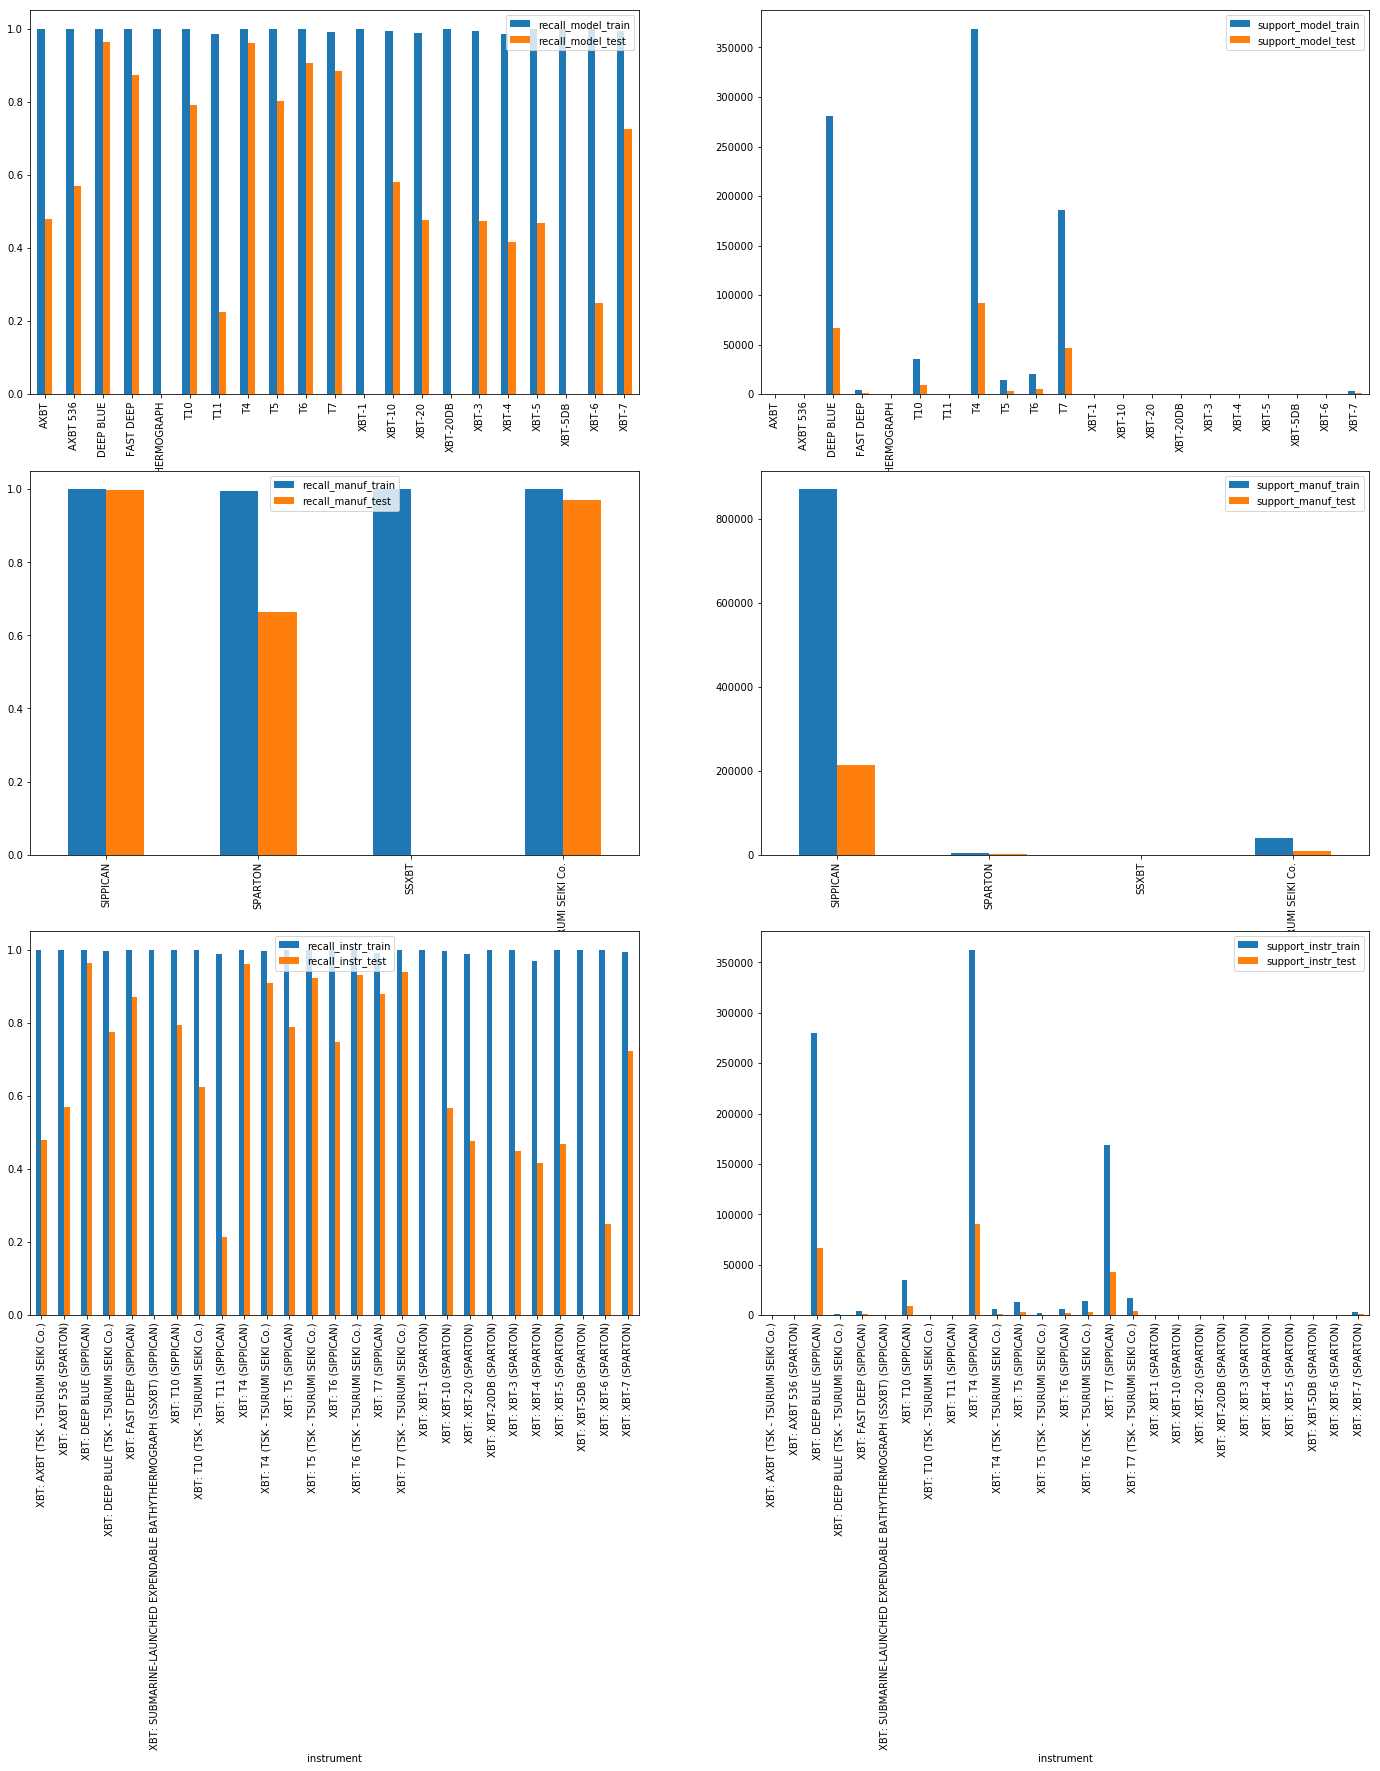

In [32]:
fig_results_all_dt = matplotlib.pyplot.figure('xbt_results_all_dt', figsize=(24,24))
axis_model_metrics = fig_results_all_dt.add_subplot(321)
_ = df_metrics_per_class_model.plot.bar(x='model',y=['recall_model_train', 'recall_model_test'], ax=axis_model_metrics)
axis_model_support = fig_results_all_dt.add_subplot(322)
_ = df_metrics_per_class_model.plot.bar(x='model',y=['support_model_train', 'support_model_test'], ax=axis_model_support)
axis_manuf_metrics = fig_results_all_dt.add_subplot(323)
_ = df_metrics_per_class_manuf.plot.bar(x='manufacturer', y=['recall_manuf_train','recall_manuf_test'],ax=axis_manuf_metrics)
axis_manuf_support = fig_results_all_dt.add_subplot(324)
_ = df_metrics_per_class_manuf.plot.bar(x='manufacturer',y=['support_manuf_train', 'support_manuf_test'], ax=axis_manuf_support)
axis_instr_metrics = fig_results_all_dt.add_subplot(325)
_ = df_metrics_per_class_instr.plot.bar(x='instrument', y=['recall_instr_train','recall_instr_test'],ax=axis_instr_metrics)
axis_instr_support = fig_results_all_dt.add_subplot(326)
_ = df_metrics_per_class_instr.plot.bar(x='instrument',y=['support_instr_train', 'support_instr_test'], ax=axis_instr_support)


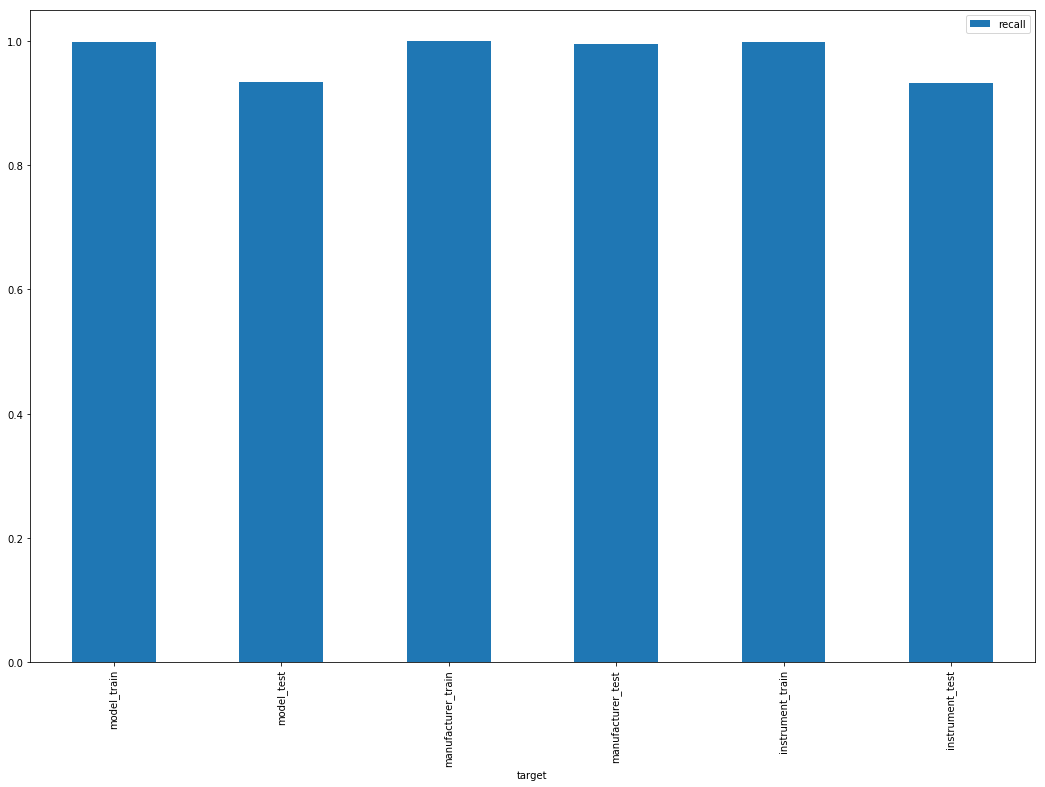

In [33]:
df_metrics_avg.plot.bar(figsize=(18,12), x='target', y='recall')

## Classification results

The contents of the XBT dataset varies over the time period, so previous papers have looked at classification accuracy (recall) year by year to evaluate how performance varies with different distribution of probe types.

To do this we apply the classifier to the train and test data for each year separetly and calculate the metrics year by year.

In [34]:
def score_year(xbt_df, year, clf, input_features, target_feature):
    X_year = xbt_df.filter_obs('year', year, ).filter_features(input_features).get_ml_dataset()[0]
    y_year = xbt_df.filter_obs('year', year, ).filter_features([target_feature]).get_ml_dataset()[0]
    y_res_year = clf.predict(X_year)
    metric_year = sklearn.metrics.precision_recall_fscore_support(
        y_year, y_res_year, average='micro')
    return metric_year

In [35]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [36]:
results_by_year = {}

In [37]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    results_by_year[year] = {
        'metric_train_model' : score_year(xbt_train_all, year, clf_dt_model1, input_feature_names, 'model'),
        'metric_test_model' : score_year(xbt_test_all, year, clf_dt_model1, input_feature_names, 'model'),
        'metric_train_manuf' : score_year(xbt_train_all, year, clf_dt_manuf1, input_feature_names, 'manufacturer'),
        'metric_test_manuf' : score_year(xbt_test_all, year, clf_dt_manuf1, input_feature_names, 'manufacturer'),
        'metric_train_instr' : score_year(xbt_train_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_test_instr' : score_year(xbt_test_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
    }
    eval_progress.value = year


In [38]:
recall_by_year = pandas.DataFrame.from_dict({ 
    'year':  list(results_by_year.keys()),
    'recall_train_model' : [m1['metric_train_model'][1] for y1,m1 in results_by_year.items()],
    'recall_test_model' : [m1['metric_test_model'][1] for y1,m1 in results_by_year.items()],
    'recall_train_manuf' : [m1['metric_train_manuf'][1] for y1,m1 in results_by_year.items()],
    'recall_test_manuf' : [m1['metric_test_manuf'][1] for y1,m1 in results_by_year.items()],
    'recall_train_instr' : [m1['metric_train_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_test_instr' : [m1['metric_test_instr'][1] for y1,m1 in results_by_year.items()],
})
    

In [39]:
model_encoder = xbt_labelled._feature_encoders['model']
manuf_encoder = xbt_labelled._feature_encoders['manufacturer']
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [40]:
eval_progress.value = env_date_ranges[environment][0]
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_model = model_encoder.transform(pandas.DataFrame(imeta_model[xbt_labelled.xbt_df.year == year]))
    xbt_model1 = model_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].model))

    y_imeta_manuf = manuf_encoder.transform(pandas.DataFrame(imeta_manufacturer[xbt_labelled.xbt_df.year == year]))
    xbt_manufacturer1 = manuf_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].manufacturer))

    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    
    
    (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = sklearn.metrics.precision_recall_fscore_support(xbt_model1, y_imeta_model,average='micro')
    (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = sklearn.metrics.precision_recall_fscore_support(xbt_manufacturer1, y_imeta_manuf,average='micro')
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='micro')

    imeta_results += [{'year': year,
                       'imeta_model_recall': im_rec_model,
                       'imeta_model_precision': im_pr_model,
                       'imeta_manuf_recall': im_rec_manuf,
                       'imeta_manuf_precision': im_pr_manuf,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                      }]
    eval_progress.value = year

In [41]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [42]:
results_df = pandas.merge(recall_by_year, imeta_res_df).merge(
    pandas.DataFrame.from_dict({
        'year': xbt_labelled['year'].value_counts(sort=False).index,
        'num_samples': xbt_labelled['year'].value_counts(sort=False).values,
    }))

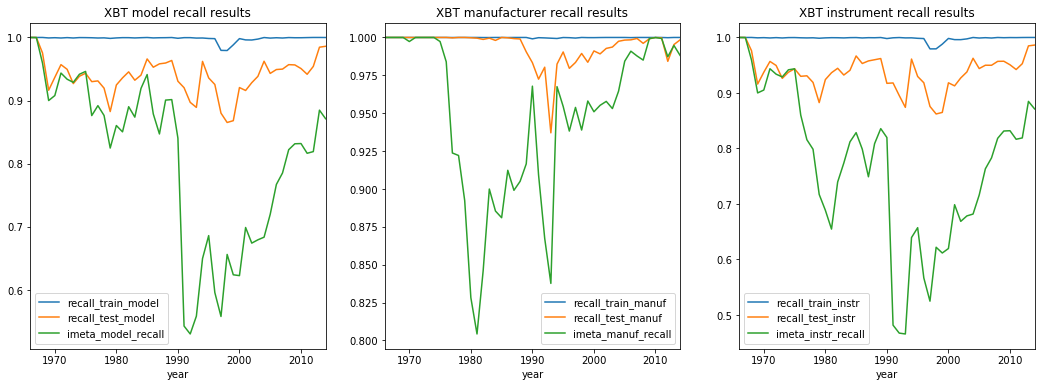

In [43]:
fig_model_recall_results = matplotlib.pyplot.figure('xbt_model_recall', figsize=(18,6))
ax_model_recall_results = fig_model_recall_results.add_subplot(131, title='XBT model recall results')
_ = results_df.plot.line(x='year',y=['recall_train_model','recall_test_model', 'imeta_model_recall'], ax=ax_model_recall_results)
ax_manuf_recall_results = fig_model_recall_results.add_subplot(132, title='XBT manufacturer recall results')
_ = results_df.plot.line(x='year',y=['recall_train_manuf','recall_test_manuf', 'imeta_manuf_recall'], ax=ax_manuf_recall_results)
ax_instr_recall_results = fig_model_recall_results.add_subplot(133, title='XBT instrument recall results')
_ = results_df.plot.line(x='year',y=['recall_train_instr','recall_test_instr', 'imeta_instr_recall'], ax=ax_instr_recall_results)

In [44]:
results_df['improvement_model'] = results_df.apply(lambda r1: ((r1['recall_test_model'] /  r1['imeta_model_recall'])-1)*100.0 , axis=1)
results_df['improvement_manuf'] = results_df.apply(lambda r1: ((r1['recall_test_manuf'] /  r1['imeta_manuf_recall'])-1)*100.0 , axis=1)
results_df['improvement_instr'] = results_df.apply(lambda r1: ((r1['recall_test_instr'] /  r1['imeta_instr_recall'])-1)*100.0 , axis=1)

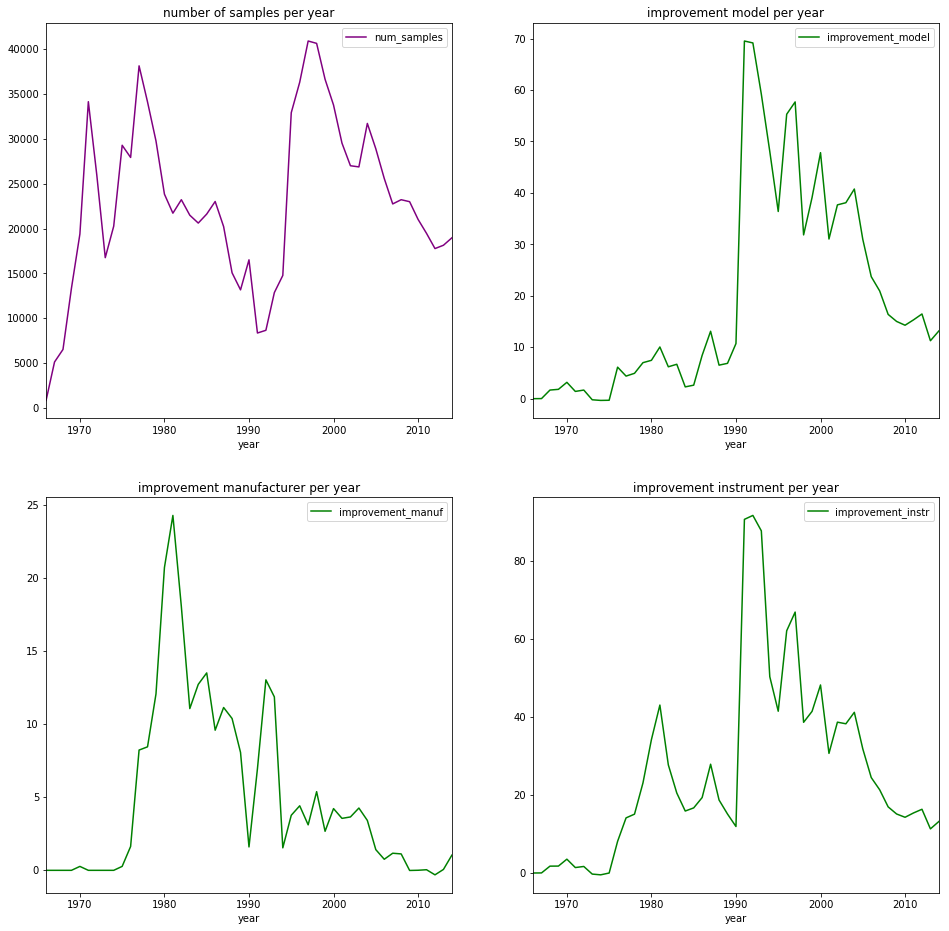

In [45]:
fig_num_samples_per_year = matplotlib.pyplot.figure('fig_num_samples_per_year', figsize=(16,16))
ax_num_samples = fig_num_samples_per_year.add_subplot(221, title='number of samples per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['num_samples'],c='purple' )
ax_num_samples = fig_num_samples_per_year.add_subplot(222, title='improvement model per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_model'], c='green' )
ax_num_samples = fig_num_samples_per_year.add_subplot(223, title='improvement manufacturer per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_manuf'], c='green' )
ax_num_samples = fig_num_samples_per_year.add_subplot(224, title='improvement instrument per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_instr'], c='green' )


## Summary
We can see so far that the basic tree approach seems to be outperforming iMeta. Further work needs to be done to calculate these results more rigorously  using cross validation. 

The next step is to explore more sophisticated tree based approaches, such an ensemble of trees (random forest) and gredient-bossted tress (XGBoost),the current state of the art in tree methods.

There are also some issues with the dataset currently being used, so these results may change when the correct version of the data is being used.

In [46]:
clf_dt_model1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)